# **Khởi tạo**

**Import thư viện**

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_absolute_error
import os

**Xử lý dữ liệu**

In [51]:
def read_file(file_name):
    # Đọc dữ liệu từ file CSV
    data = pd.read_csv(file_name)

    # Chuyển cột 'Date' thành kiểu dữ liệu datetime và đặt làm index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)

    # Chuyển đổi các cột khác sang dạng số nếu cần thiết
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    # Tiền xử lý các cột khác nếu cần thiết

    # Sắp xếp dữ liệu theo thời gian từ quá khứ đến hiện tại
    data.sort_index(inplace=True)
    data = data.reset_index()['Price']

    return data

**Xây dựng mô hình**

In [52]:
# Hàm tính MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [53]:
def RNN_prediction(name, file_name, train_ratio=0.7, test_ratio=0.2, forecast_days=30):
    # Đọc dữ liệu từ file CSV
    data = read_file(file_name)

    # Scaler data
    scaler = MinMaxScaler(feature_range=(0,1))
    data = scaler.fit_transform(np.array(data).reshape(-1,1))

    # Chia train, test
    train_size = int(train_ratio * len(data))
    test_size = int(test_ratio * len(data))
    train_data = data[:train_size]
    test_data = data[train_size:train_size+test_size]

    # Hàm Create Dataset
    def create_dataset(dataset, time_step=1):
        dataX, dataY = [], []
        for i in range(len(dataset)-time_step-1):
            a = dataset[i:(i+time_step), 0]
            dataX.append(a)
            dataY.append(dataset[i + time_step, 0])
        return np.array(dataX), np.array(dataY)
    
    # Reshape into X=t,t+1,t+2..t+99 and Y=t+100
    time_step = 100
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)

    # Reshape input to be [samples, time steps, features] which is required for LSTM
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    # Define RNN Model
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(time_step, 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Fit mô hình với dữ liệu train
    model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=0)

    # Dự báo dữ liệu test
    train_predict = model.predict(X_train)
    y_pred = model.predict(X_test)

    # Đánh giá độ chính xác thuật toán bằng RMSE
    test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
    print('Testing RMSE:', test_rmse)

    # Đánh giá độ chính xác thuật toán bằng MAE
    test_mae = mean_absolute_error(y_test, y_pred)
    print('Testing MAE:', test_mae)
    
    # Đánh giá độ chính xác thuật toán bằng MAPE
    test_mape = mean_absolute_percentage_error(y_test, y_pred)
    print('Testing MAPE:', test_mape)
    
    # Dự báo n ngày tiếp theo
    x_input = test_data[-time_step:].reshape(1, -1)
    temp_input = list(x_input[0])
    lst_output = []

    while len(lst_output) < forecast_days:
        if len(temp_input) > time_step:
            x_input = np.array(temp_input[1:])
            x_input = x_input.reshape(1, -1)
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            temp_input = temp_input[1:]
            lst_output.extend(yhat.tolist())
        else:
            x_input = x_input.reshape((1, time_step, 1))
            yhat = model.predict(x_input, verbose=0)
            temp_input.extend(yhat[0].tolist())
            lst_output.extend(yhat.tolist())

    # Chuẩn hóa dữ liệu y_pred
    train_predict=scaler.inverse_transform(train_predict)
    y_pred=scaler.inverse_transform(y_pred)
    
    # Vẽ hình
    train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
    plt.plot(scaler.inverse_transform(train_data))
    test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, scaler.inverse_transform(test_data))
    test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
    plt.plot(test_data_index, y_pred)
    predict_data_index = pd.RangeIndex(start=len(data), stop=len(data)+forecast_days, step=1)
    plt.plot(predict_data_index, scaler.inverse_transform(lst_output))
    plt.legend(['Train', 'Test', 'Predict', f'Predict {forecast_days} days'])
    plt.show()
    

# **BIDV**

## **30 ngày**

**BIDV 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.16930253314238128
Testing MAE: 0.019814484150482675
Testing MAPE: 19.707809182814728


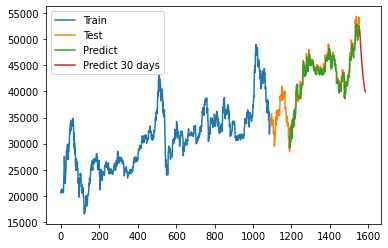

In [54]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**BIDV 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.1313140632929405
Testing MAE: 0.019155322512915043
Testing MAPE: 13.529549847120176


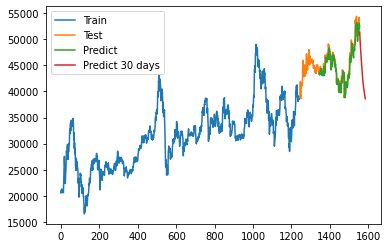

In [55]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**BIDV 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.10679257485250641
Testing MAE: 0.018538811261591875
Testing MAPE: 9.899075841155094


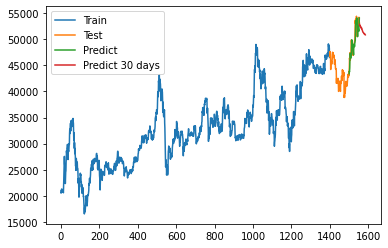

In [56]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**BIDV 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.1718543914827401
Testing MAE: 0.021399794572630346
Testing MAPE: 19.92741058733099


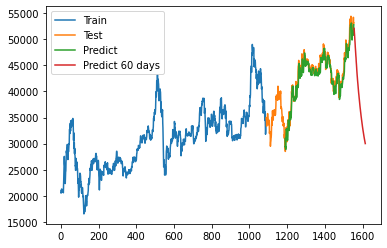

In [57]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**BIDV 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.13195040715648623
Testing MAE: 0.025496504650310725
Testing MAPE: 13.52675316365983


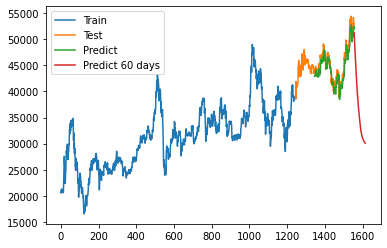

In [58]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**BIDV 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Testing RMSE: 0.10773298571059028
Testing MAE: 0.02199199981097119
Testing MAPE: 9.96207899544209


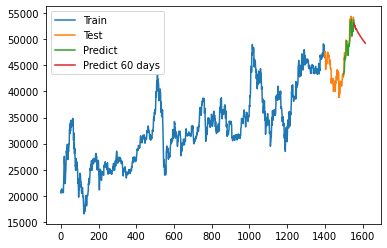

In [59]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**BIDV 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.17229116295375202
Testing MAE: 0.02356574819232378
Testing MAPE: 19.93528623678322


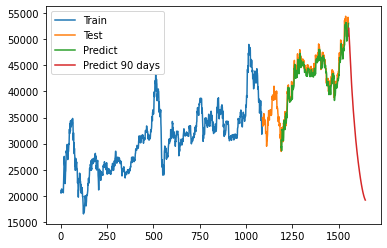

In [60]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**BIDV 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.1312788869612861
Testing MAE: 0.015391222492017157
Testing MAPE: 13.615150142166149


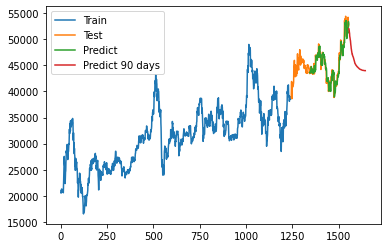

In [61]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**BIDV 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.1075589195945729
Testing MAE: 0.019596225418851955
Testing MAPE: 10.023616778845708


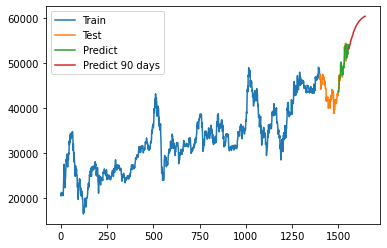

In [62]:
RNN_prediction('BIDV', '../Dataset/BID Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **MBB**

## **30 ngày**

**MBB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.12591639756312015
Testing MAE: 0.017211911171746037
Testing MAPE: 16.234398611398817


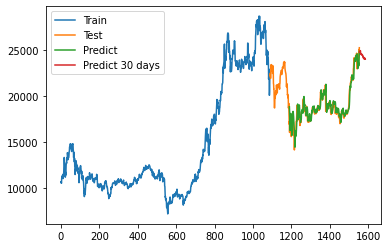

In [63]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**MBB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.13639917845163274
Testing MAE: 0.014124501866617874
Testing MAPE: 16.990418937353972


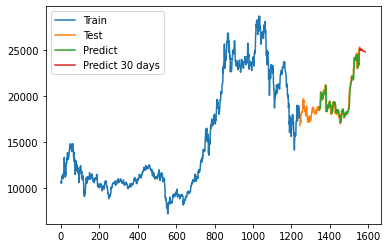

In [64]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**MBB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.09488876411880384
Testing MAE: 0.01486506907630812
Testing MAPE: 10.52093234236566


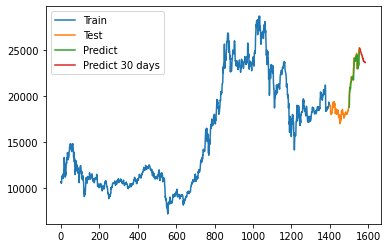

In [65]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**MBB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.1271197948502057
Testing MAE: 0.013970599808028368
Testing MAPE: 16.28979321469413


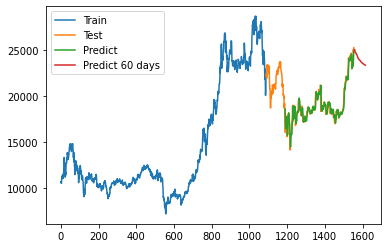

In [66]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**MBB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.13763638173378334
Testing MAE: 0.015543093019434953
Testing MAPE: 17.318076142811417


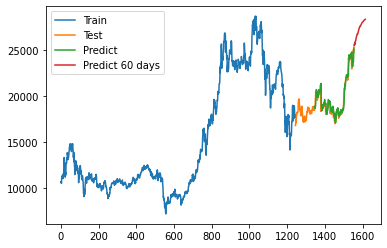

In [67]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**MBB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.09627819482505813
Testing MAE: 0.019427233038266226
Testing MAPE: 10.637825185873712


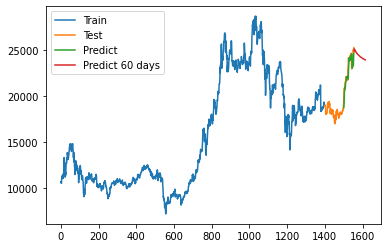

In [68]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**MBB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing RMSE: 0.12727518463732795
Testing MAE: 0.013289287752838736
Testing MAPE: 16.32140421913226


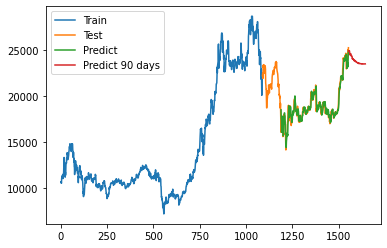

In [69]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**MBB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Testing RMSE: 0.13741923476819037
Testing MAE: 0.010583047640328669
Testing MAPE: 17.074632258552928


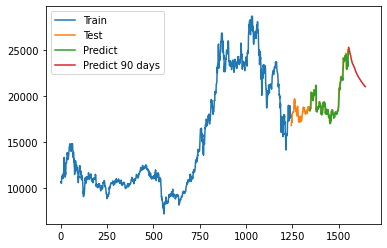

In [70]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**MBB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.09572019684418859
Testing MAE: 0.01800745286371233
Testing MAPE: 10.590374751805669


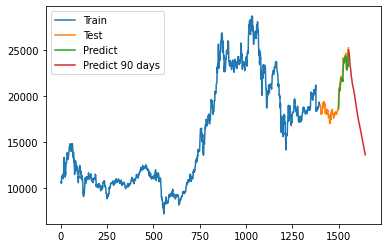

In [71]:
RNN_prediction('MBB', '../Dataset/MBB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)

# **VCB**

## **30 ngày**

**VCB 7:3 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Testing RMSE: 0.1560264213859922
Testing MAE: 0.021097730118856652
Testing MAPE: 17.172741024808722


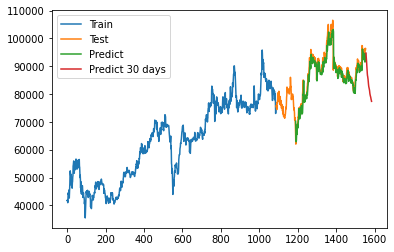

In [72]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=30)

**VCB 8:2 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.11384564526236945
Testing MAE: 0.019744900626648212
Testing MAPE: 11.126611533494094


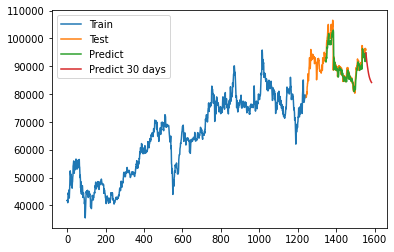

In [73]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=30)

**VCB 9:1 predict 30 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.06444345891079746
Testing MAE: 0.01924913013186187
Testing MAPE: 6.397040168263766


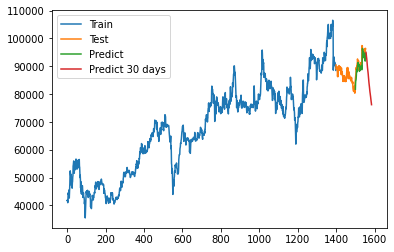

In [74]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=30)

## **60 ngày**

**VCB 7:3 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.15629044926515548
Testing MAE: 0.015922266115342764
Testing MAPE: 17.341555861115395


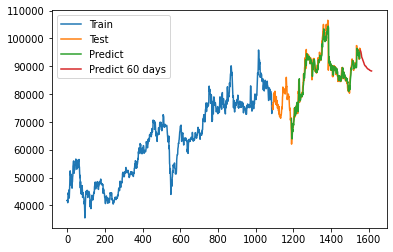

In [75]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=60)

**VCB 8:2 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Testing RMSE: 0.11663445290965832
Testing MAE: 0.015324002426705417
Testing MAPE: 11.469824655757197


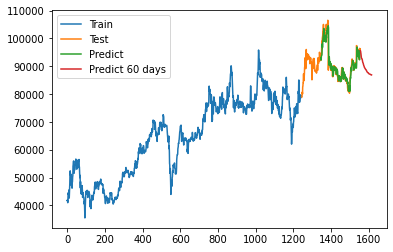

In [76]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=60)

**VCB 9:1 predict 60 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.06280039793695569
Testing MAE: 0.014553135599013776
Testing MAPE: 6.252809670309654


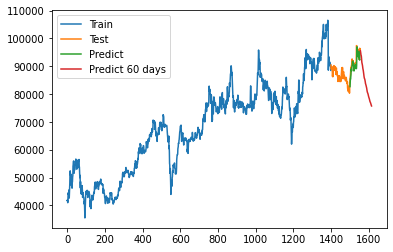

In [77]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=60)

## **90 ngày**

**VCB 7:3 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.1564515561156771
Testing MAE: 0.02049896544654029
Testing MAPE: 17.2458429769808


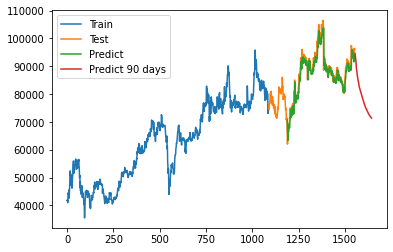

In [78]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.7, test_ratio=0.3, forecast_days=90)

**VCB 8:2 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Testing RMSE: 0.1156534097198949
Testing MAE: 0.018880657893198465
Testing MAPE: 11.342052053291658


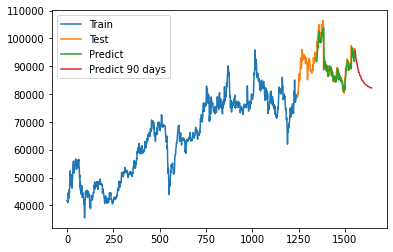

In [79]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.8, test_ratio=0.2, forecast_days=90)

**VCB 9:1 predict 90 days**

c:\Users\My PC\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Testing RMSE: 0.06170465297589328
Testing MAE: 0.011723339212586155
Testing MAPE: 6.180695665435262


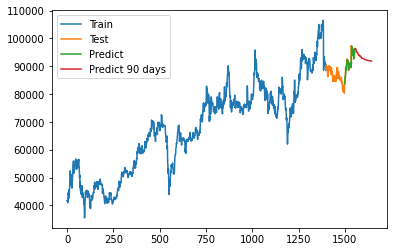

In [80]:
RNN_prediction('VCB', '../Dataset/VCB Historical Data.csv', train_ratio=0.9, test_ratio=0.1, forecast_days=90)